# Demo Notebook: Latent Space Surrogate Model of MIKE21 

In [1]:
%load_ext autoreload
%autoreload 2
from mike21modeltools.LatentModel.preprocessing import prepare_datasets,combine_mike_files,generate_raw_images
from mike21modeltools.LatentModel.training import EarlyStopping, train_model
from mike21modeltools.LatentModel.model import TCN_LSTMModel
from mike21modeltools.LatentModel.dataset import SequenceDatasetPCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from mike21modeltools.LatentModel.utils import (
    flatten_and_normalize,
    plot_loss,
    evaluate,
    compare_maxHs,
    get_model_outputs,
    plot_pixel_value_comparison,
    plot_model_predictions)

## 1. Pre-Processing of MIKE21 input from dfsu_grid

### 1.1 Concat all grid data from dfsu_grid folder

In [2]:
input_path = 'Data/dfsu_grid/'
output_path = 'Data/mike_grid_test.csv'
# Combine Mike files will filter inconsistent sequence data and fillna Hs with 0
mike = combine_mike_files(input_path, output_path)

In [3]:
# Convert to 1D data to 2D format (it takes around 2 mins)
npy = generate_raw_images(mike) #load all tracks

# use generate_raw_images_one_track to load only one track for testing a specific track id performance
#npy = generate_raw_images_one_track(mike, 0)

### 1.2 Convert 1D to 2D data

In [4]:
sequence_length = 97 
# Prepare train, val and test datasets
train_data, val_data, test_data = prepare_datasets(npy, sequence_length)

### 1.3 Apply principal component analysis (PCA) to the data

In [5]:
### Apply principal component analysis (PCA) to the data
num_pca_components = 24 ## adjust the number of components if needed
scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()

# Flatten and normalize before PCA
train_data_flat_normalized = flatten_and_normalize(train_data, scaler_input)
# Use separated scalers to make inverse_transform below more accurate
train_targets_flat_normalized = flatten_and_normalize(train_data[:, :, :, :1], scaler_target) 

# Initialize PCA models
pca_model_input = PCA(n_components=num_pca_components)
pca_model_target = PCA(n_components=num_pca_components)

# Fit PCA models and transform data
train_data_pca = pca_model_input.fit_transform(train_data_flat_normalized)
train_targets_pca = pca_model_target.fit_transform(train_targets_flat_normalized)

### 2. Prepare Customer Dataset for traininig

In [6]:
train_dataset = SequenceDatasetPCA(train_data, sequence_length, pca_model_input=pca_model_input, pca_model_target=pca_model_target)
val_dataset = SequenceDatasetPCA(val_data, sequence_length, pca_model_input=pca_model_input, pca_model_target=pca_model_target)
test_dataset = SequenceDatasetPCA(test_data, sequence_length, pca_model_input=pca_model_input, pca_model_target=pca_model_target)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
# Hyperparameters
hidden_size = 128    # Number of hidden units in LSTM
num_layers = 2       
output_size = 1      # Hs
num_channels = [64, 128] 
kernel_size = 3      # Kernel size for TCN
dropout = 0.5        # Dropout rate

## 5. Training with earlying stopping to avoid overfitting

/Users/timdu/anaconda3/envs/miketest/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Train Loss: 0.0155, Val Loss: 0.0135, MSE: 0.0270, R²: 0.0533
Epoch 2/30, Train Loss: 0.0063, Val Loss: 0.0073, MSE: 0.0145, R²: 0.2573
Epoch 3/30, Train Loss: 0.0052, Val Loss: 0.0062, MSE: 0.0125, R²: 0.3307
Epoch 4/30, Train Loss: 0.0042, Val Loss: 0.0062, MSE: 0.0125, R²: 0.3598
EarlyStopping counter: 1 out of 6
Epoch 5/30, Train Loss: 0.0044, Val Loss: 0.0083, MSE: 0.0166, R²: 0.3361
EarlyStopping counter: 2 out of 6
Epoch 6/30, Train Loss: 0.0036, Val Loss: 0.0097, MSE: 0.0194, R²: 0.1770
EarlyStopping counter: 3 out of 6
Epoch 7/30, Train Loss: 0.0029, Val Loss: 0.0056, MSE: 0.0112, R²: 0.4683
Epoch 8/30, Train Loss: 0.0025, Val Loss: 0.0046, MSE: 0.0092, R²: 0.5049
Epoch 9/30, Train Loss: 0.0024, Val Loss: 0.0047, MSE: 0.0094, R²: 0.5296
EarlyStopping counter: 1 out of 6
Epoch 10/30, Train Loss: 0.0023, Val Loss: 0.0052, MSE: 0.0105, R²: 0.5353
EarlyStopping counter: 2 out of 6
Epoch 11/30, Train Loss: 0.0022, Val Loss: 0.0059, MSE: 0.0118, R²: 0.4413
EarlyStopping 

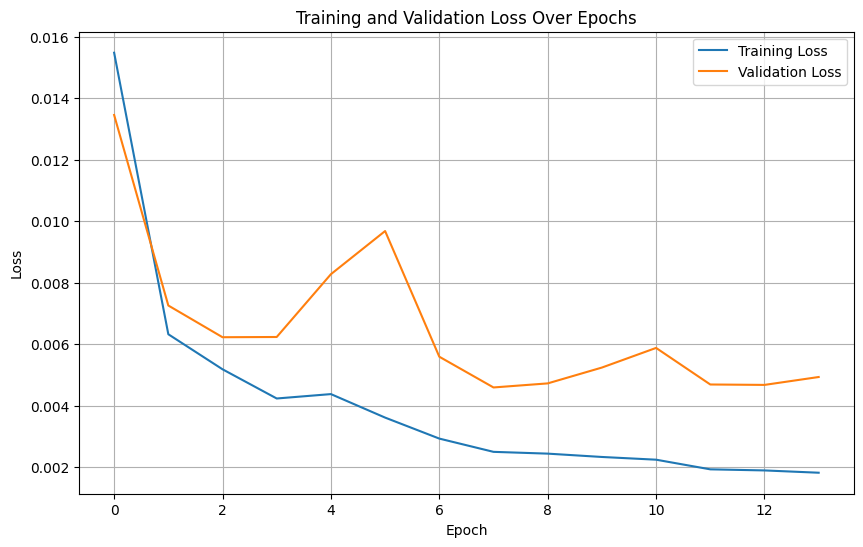

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCN_LSTMModel(num_inputs=num_pca_components, num_channels=[64, 128], 
                      hidden_size=128, num_layers=2, output_size=num_pca_components, seq_length=sequence_length).to(device)

criterion = nn.SmoothL1Loss() 
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# decay LR by a factor of 0.2 if the validation loss does not decrease for 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
early_stopping = EarlyStopping(patience=6, verbose=True)

train_losses, val_losses, val_metrics = train_model(model, train_loader, 
                                                    val_loader, criterion,num_pca_components, optimizer, scheduler, early_stopping, device, num_epochs=30)

## The R2 score is calculated on the latent space, not the original space
plot_loss(train_losses, val_losses)

In [9]:
##save model
#torch.save(model.state_dict(), 'Data/Latentmodel.pth')

## 6. Results

### 6.1 Model's overall performance on Test Data

In [10]:
evaluate(model, test_loader, criterion, test_dataset)

R² score: 0.968
MSE: 0.112
MAE: 0.158
Percentage of Underestimate: 1.94%
Cropped R²: 0.964
Cropped MSE: 0.090
Cropped MAE: 0.142
Percentage of large errors (actual >= 2m and error > 1): 1.26%


### 6.2 Model's peak value performance on one of the tracks

Mean Absolute Error: 0.2277790510234403
Mean Squared Error: 0.12247167819270226


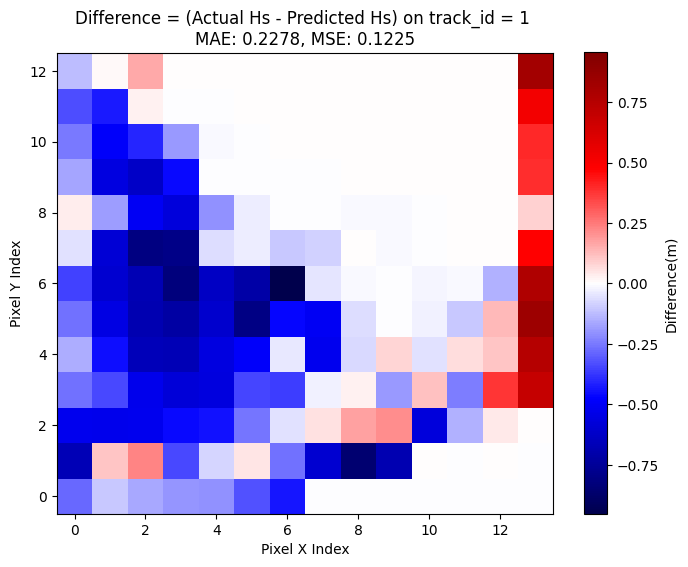

In [11]:
compare_maxHs(model, test_loader, test_dataset, device,  sequence_index=1)

### 6.3 Model's whole track prediction performance on selected grid and track

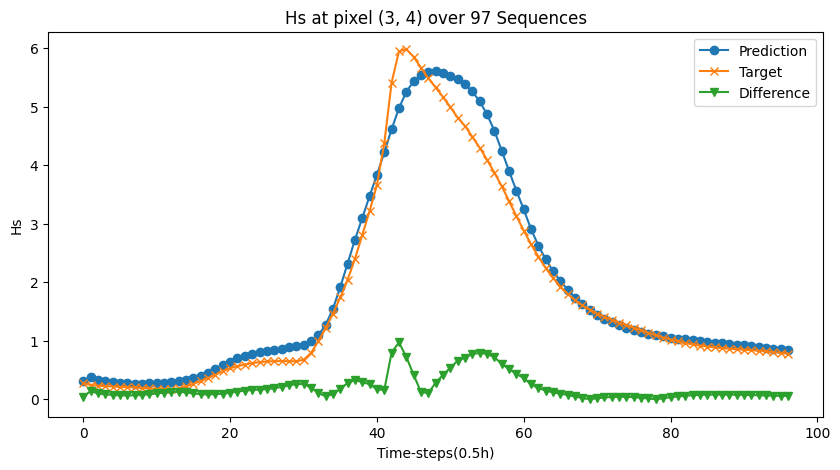

In [12]:
# Assuming test_dataset and model are already defined
denormalized_outputs, denormalized_targets = get_model_outputs(model, test_dataset, device,sequence_index=3) # sequence_index is the index of the sequence of storm

# Determine the sequence length from the denormalized data

plot_pixel_value_comparison(denormalized_outputs, denormalized_targets, pixel_x=3, pixel_y=4)

### 6.4 Visualise whole track predction

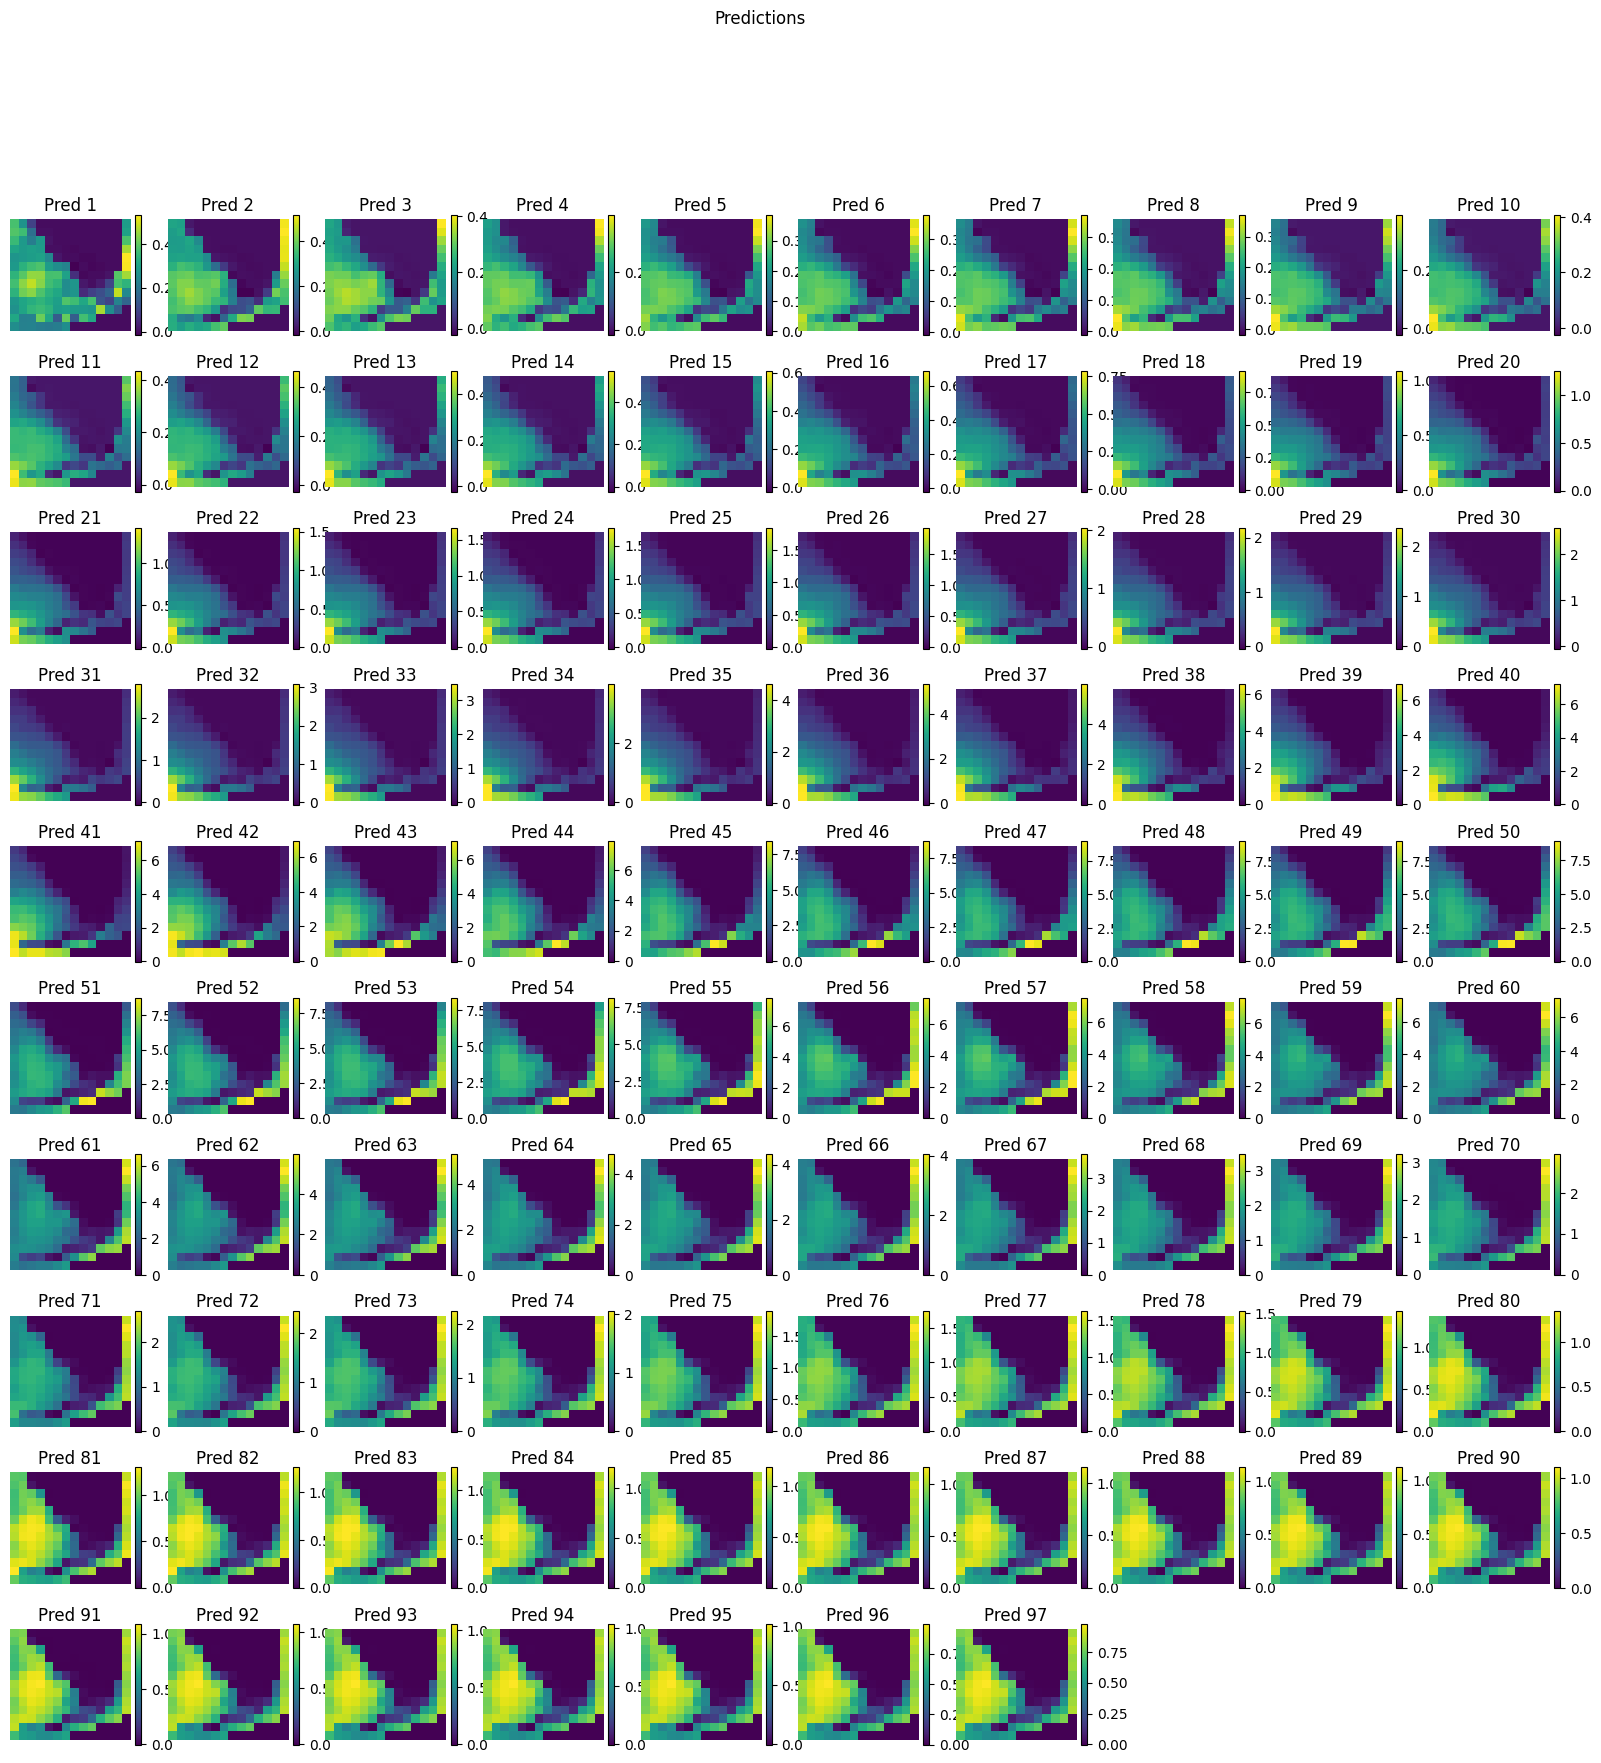

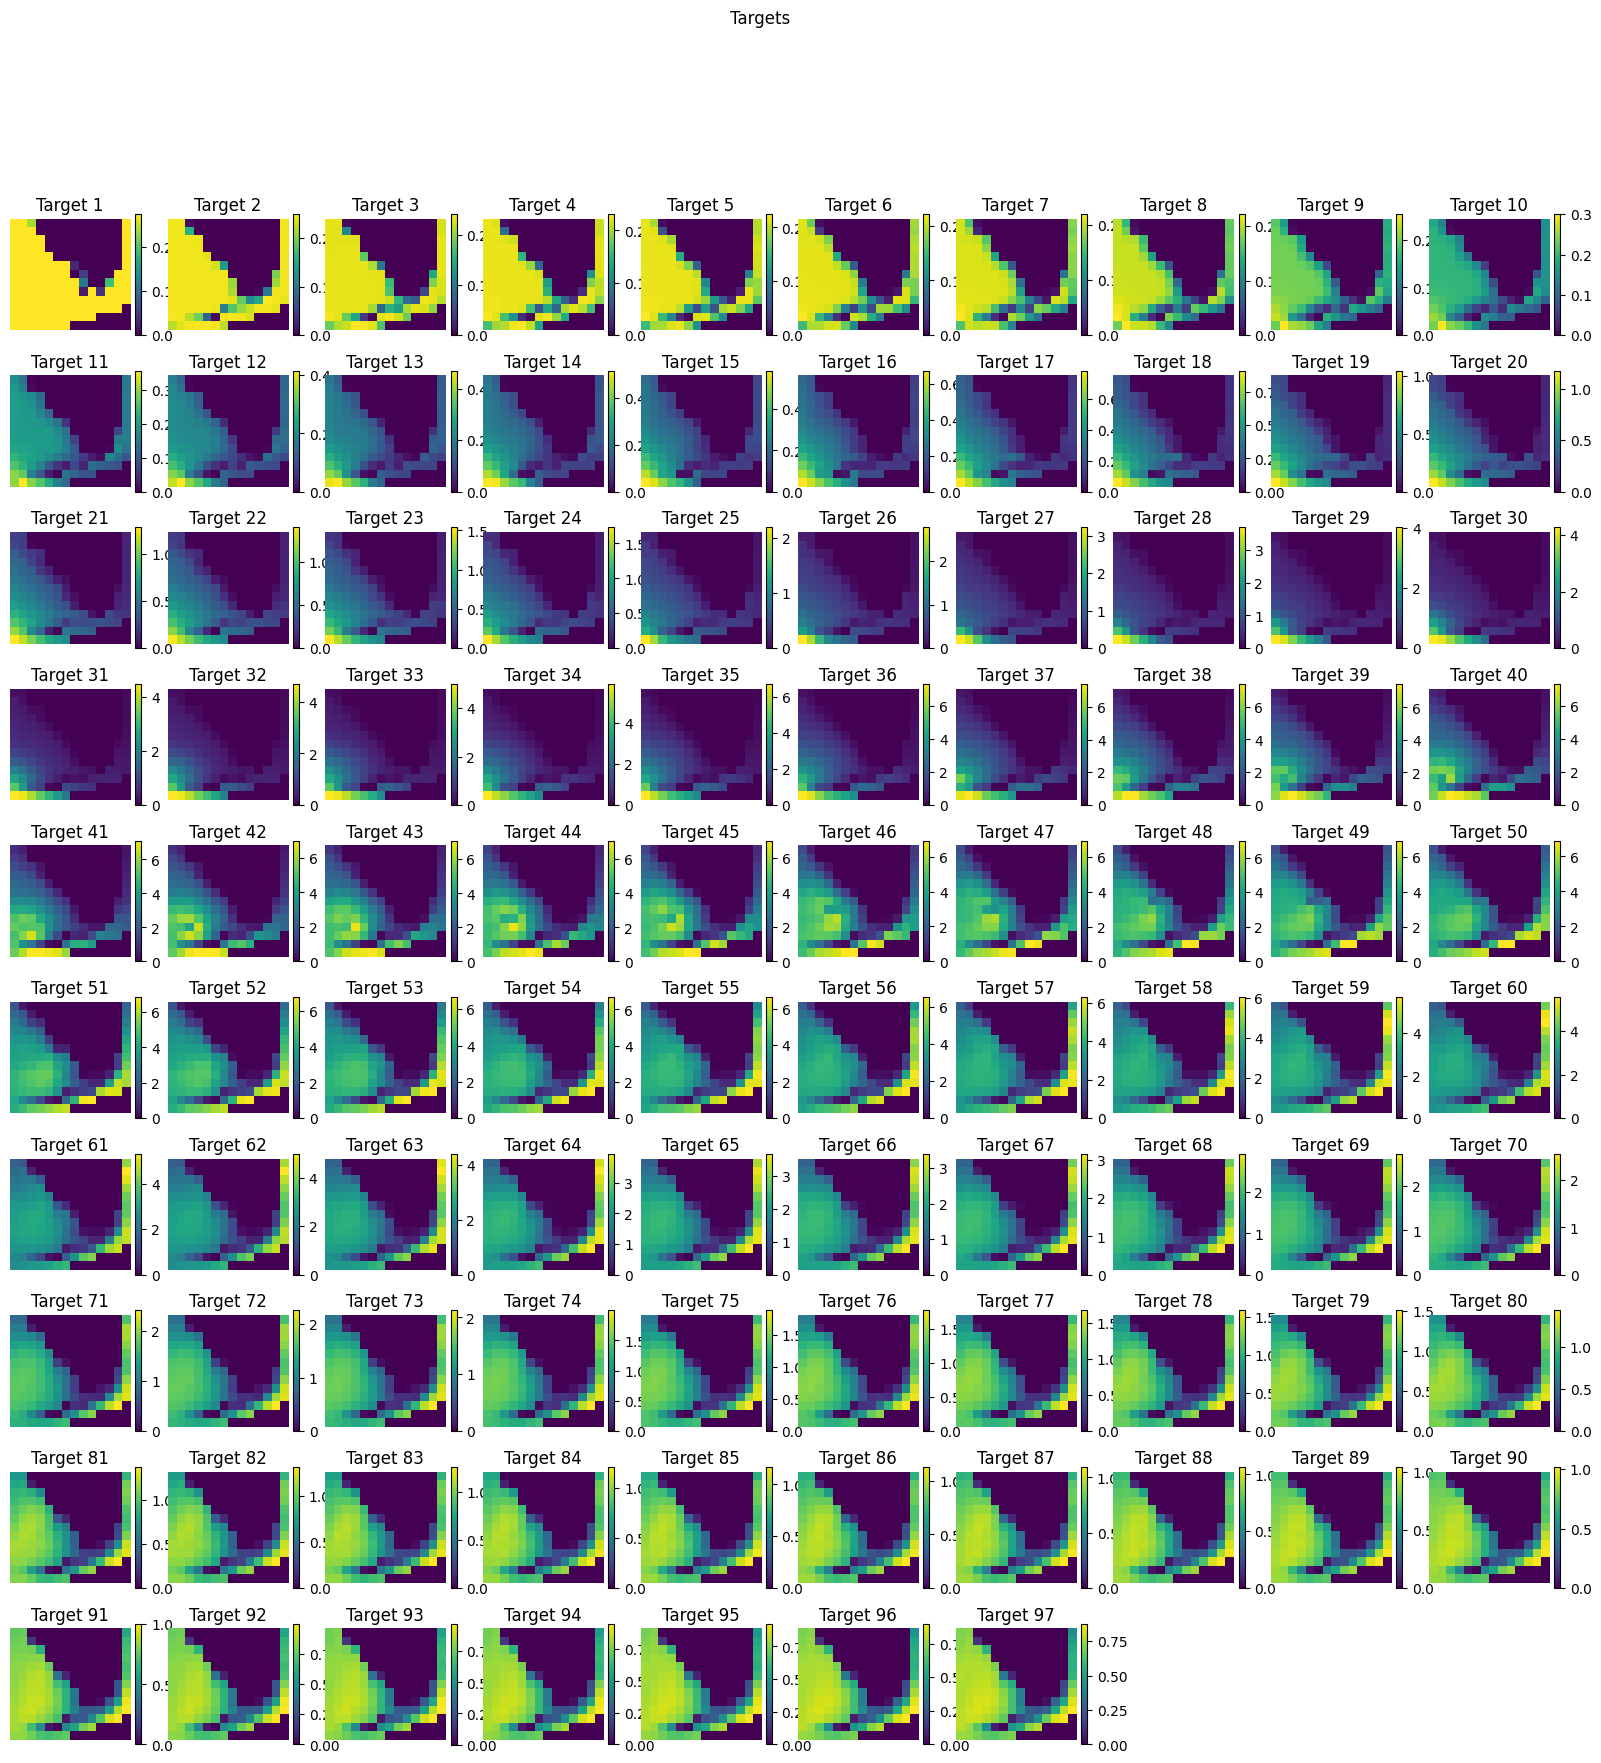

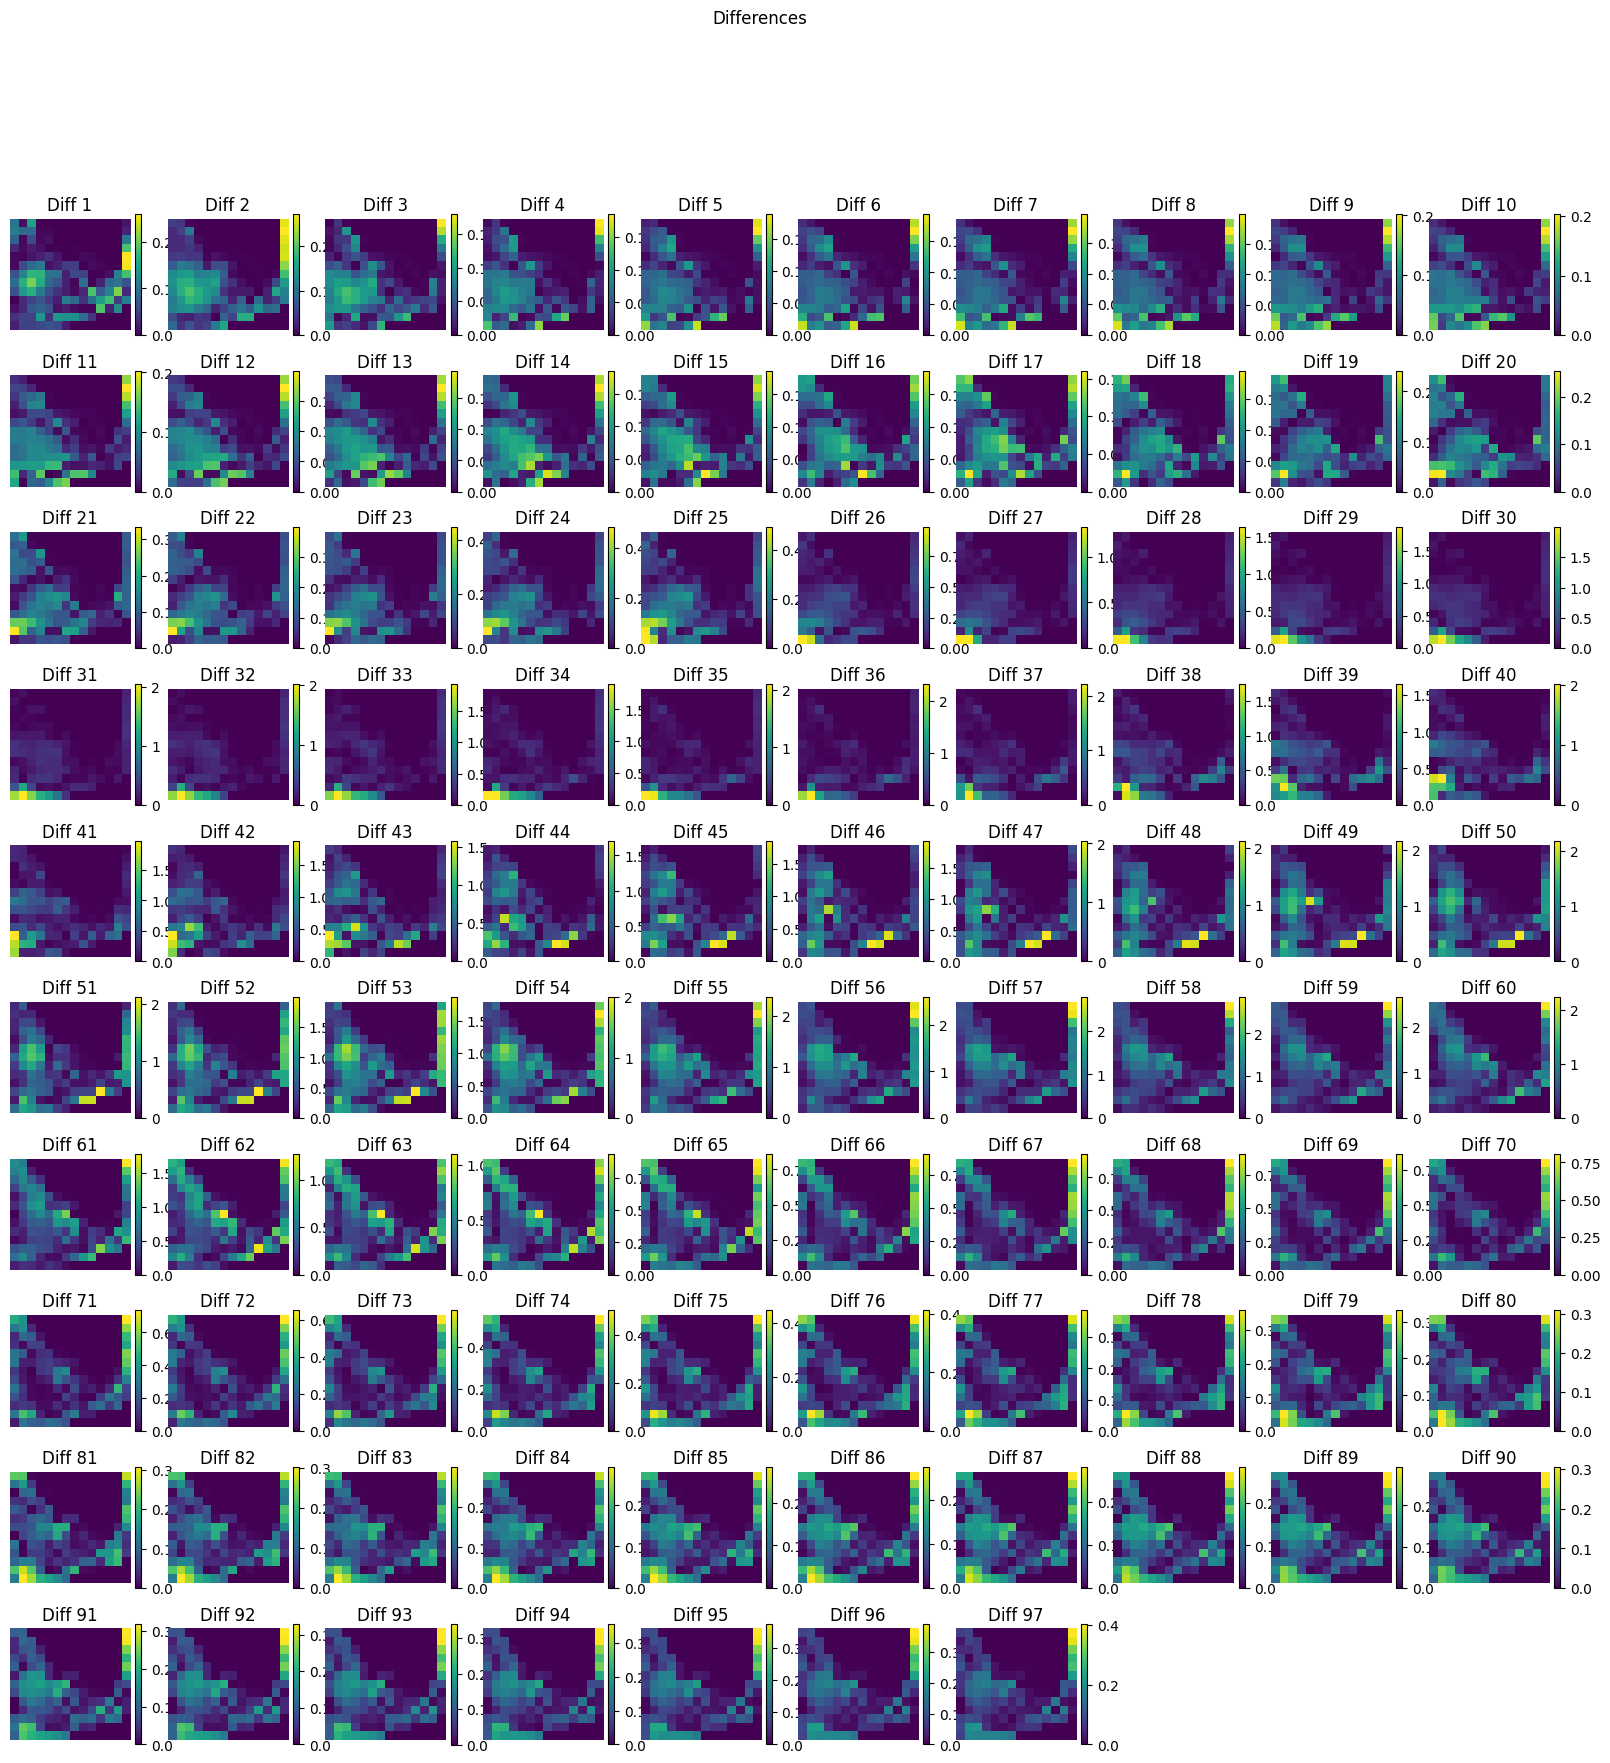

In [13]:
plot_model_predictions(denormalized_outputs,denormalized_targets,sequence_length=97)